## Background

Managing missed patient appointments represent a challenge for those working in
health care systems.Non-attendance at appointments decreases healthcare revenue, causes suboptimal use of clinical and administrative staff, can impact wait times for patients, and negatively affects continuity of care.
The first step to solving the problem of missed appointments is identifying why a patient skips a scheduled visit in the first place. What trends are there among patients with higher absence rates? Are there demographic indicators or perhaps time-variant relationships hiding in the data? Ultimately, it was these questions that drove my exploratory data analysis. I was curious as to the reasons behind missed appointments, and wanted to examine the data to identify any trends present. I choose this problem because I believe it is an excellent example of how data science and analysis can reveal relationships which can be implemented in the real-world to the benefit of society.

## Introduction to Dataset

I wanted to choose a dataset that was both relatable and could be used to make 
smarter decisions. Therefore, I decided to work with medical appointment no shows 
data available on Kaggle.
There were a total of 14 variables I included from the original data. The variables and the description of the values are as follows:
1. PatientId: unique ID associated with a patient
2. AppointmentID: unique ID for each appointment.
3. Gender:  M or F
4. ScheduledDay :  date and time appointment was Scheduled.    
5. AppointmentDay : date of appointment without time.
6. Age : Integer age of patient.         
7. Neighbourhood :  Neighbourhood of the hospital.  
8. Scholarship : 0 or 1 indicating whether the family of the patient takes part in the Bolsa Familia Program     
9. HyperTension  :0 or 1 for condition
10. Diabetes  :  0 or 1 for condition (1 means patient was scheduled to treat condition)       
11. Alcoholism :  0 or 1 for condition    
12. HandiCap  : 0 or 1 for condition       
13. SMS_received  :  0 or 1 (1 for sending remainder)
14. No-show :  'Yes'/'No'


import necessary libraries

In [1]:
# make jupyter cells wider

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import datetime as datetime
from sklearn import preprocessing
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import chi2_contingency
from copy import deepcopy

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, cohen_kappa_score, precision_score, recall_score
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
#from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier

import matplotlib
#matplotlib.style.use('ggplot')
sns.set(font_scale=1.5)

In [2]:
no_showup=pd.read_csv('C:/Users/Lenovo/Downloads/noshowappointments/KaggleV2-May-2016.csv')
no_showup.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


## Data wrangling:

Let’s take a look at the structure of the dataframe to identify cleaning that may need to be performed. I am renaming few of the columns to appropriate names. data is already clean without any missing values.

In [3]:
no_showup.rename(columns = {'Hipertension':'HyperTension' , 'Handcap':'HandiCap'},inplace=True)
no_showup.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'HyperTension',
       'Diabetes', 'Alcoholism', 'HandiCap', 'SMS_received', 'No-show'],
      dtype='object')

In [4]:
no_showup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
HyperTension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
HandiCap          110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
#droping the column if all the values are null
no_show=no_showup.dropna(axis='columns',how='all')
no_show.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,HyperTension,Diabetes,Alcoholism,HandiCap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [6]:
#selecting the valid age
#no_show = no_show[(no_show.Age > 0) & (no_show.Age <= 100)]

In [7]:
#Converting the date columns to  datetime64 format
no_show['ScheduledDay'] = no_show.ScheduledDay.apply(np.datetime64)
no_show['AppointmentDay'] = no_show.AppointmentDay.apply(np.datetime64)
no_show['WaitTime']=no_show.AppointmentDay-no_show.ScheduledDay
no_show.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,HyperTension,Diabetes,Alcoholism,HandiCap,SMS_received,No-show,WaitTime
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1 days +05:21:52
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1 days +07:51:33
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1 days +07:40:56
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,-1 days +06:30:29
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,-1 days +07:52:37


In [8]:
# checking if there are any missing values

no_show.fillna('')
no_show.isnull().values.any()


False

In [9]:
for i in no_show.columns:
    unique_count=no_show[i].nunique()
    if unique_count < 20:
       print(no_show[i].value_counts())
       print('---------')
       print('\n')

F    71840
M    38687
Name: Gender, dtype: int64
---------


0    99666
1    10861
Name: Scholarship, dtype: int64
---------


0    88726
1    21801
Name: HyperTension, dtype: int64
---------


0    102584
1      7943
Name: Diabetes, dtype: int64
---------


0    107167
1      3360
Name: Alcoholism, dtype: int64
---------


0    108286
1      2042
2       183
3        13
4         3
Name: HandiCap, dtype: int64
---------


0    75045
1    35482
Name: SMS_received, dtype: int64
---------


No     88208
Yes    22319
Name: No-show, dtype: int64
---------




In [10]:
#converting gender and no-show columns to numeric values
le = preprocessing.LabelEncoder()
le.fit(['F', 'M'])
no_show['num_gender']=le.transform(no_show['Gender'])
le.fit(['No', 'Yes'])
no_show['numNoshow']=le.transform(no_show['No-show'])

In [11]:
# there is 1 invalid record which is negative. I am selecting only the valid age.
no_show=no_show[no_show.Age>=0]

In [12]:
no_show['Waitdays'] = no_show['WaitTime'].dt.days
#Some records has scheduledday greater than appointmentday. so I am deleting those records
no_show=no_show[no_show['Waitdays']>-1]


In [13]:
no_show.describe()

,PatientId,AppointmentID,Age,Scholarship,HyperTension,Diabetes,Alcoholism,HandiCap,SMS_received,WaitTime,num_gender,numNoshow,Waitdays
count,7.195900e+04,7.195900e+04,71959.000000,71959.000000,71959.000000,71959.000000,71959.000000,71959.000000,71959.000000,71959,71959.000000,71959.000000,71959.000000
mean,1.452606e+14,5.655042e+06,38.502564,0.092706,0.208897,0.074723,0.025320,0.020025,0.493086,15 days 03:50:06.596145,0.331981,0.285190,14.642018
std,2.535667e+14,7.472189e+04,22.925421,0.290021,0.406523,0.262946,0.157096,0.154072,0.499956,16 days 11:46:35.560378,0.470927,0.451508,16.494334
min,3.921784e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 03:16:20,0.000000,0.000000,0.000000
25%,3.968099e+12,5.617796e+06,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3 days 15:14:50,0.000000,0.000000,3.000000
50%,2.991891e+13,5.661165e+06,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8 days 16:25:29,0.000000,0.000000,8.000000
75%,9.371660e+13,5.707178e+06,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,21 days 15:01:04.500000,1.000000,1.000000,21.000000
max,9.999320e+14,5.784985e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,178 days 13:19:01,1.000000,1.000000,178.000000


The summary of the no_show dataframe gives lot of details. Minimum age is 0 and maximum age is 115. Since there are only 4 patients with age greater then 100. I am considering it as valid.
This data summary shows that 20% of appointments are missed based on the mean for the numNoshow field. The rates for the various patient conditions can also be seen, and the most commonly coded reason for an appointment is hypertension at nearly 19.7% of visits.

In [14]:
def get_age_bucket(age):
    if age <= 18:
        return '0-18'
    elif 18 < age <= 24:
        return '18-24'
    elif 25 <= age <=34:
        return '25-34'
    elif 35 <= age <= 44:
        return '35-44'
    elif 45 <= age <= 54:
        return '45-54'
    elif 55 <= age <= 64:
        return '55-64'
    elif 65 <= age:
        return '65+'
    else:
        return '100+'
    
no_show['age_bucket'] = no_show['Age'].apply(lambda x: get_age_bucket(x))

In [15]:
def get_waitdays_bucket(waitdays):
    if waitdays <= 25:
        return '0-25'
    elif 25 < waitdays <= 50:
        return '26-50'
    elif 50 < waitdays <=75:
        return '51-75'
    elif 75 < waitdays <= 100:
        return '76-100'
    elif 100 < waitdays <= 125:
        return '101-125'
    elif 125 < waitdays <= 150:
        return '126-150'
    elif 150 < waitdays <= 175:
        return '151-175'
    else:
        return '176+'
    
no_show['waitdays_bucket'] = no_show['Waitdays'].apply(lambda x: get_waitdays_bucket(x))

In [16]:
# single function to visualize feature counts and relationship with no show

def visualize_feature(df, feature):
    if no_show[feature].nunique()> 4:
        figsize = (18, 8)
    else:
        figsize = (8, 3)
        
    if feature in ['age_bucket','Neighbourhood','Waitdays','day']:
        kind = 'bar'
    else:
        kind = 'barh'
        
    sort_column = feature    
    p = no_show.pivot_table(index=feature, values='numNoshow', aggfunc={'numNoshow': ['count', 'mean']}).reset_index()
    p['count%'] = p['count'] / p['count'].sum()
    p['mean']=1-p['mean']
    p = p[[feature, 'count', 'count%', 'mean']]
    p.rename(index=str, columns={'mean': 'probability'}, inplace=True)
    display(p.round({'count%': 3, 'probability': 3}).sort_values(by='probability', ascending=False))
    pivot_mean = no_show.pivot_table(index=feature, values='numNoshow', aggfunc='mean').reset_index().sort_values(by=sort_column, ascending=True)
    pivot_mean['noshow'] = 1 - pivot_mean['numNoshow']                                                                                                             
    ax = pivot_mean.plot(x=feature, y='noshow', kind=kind, figsize=figsize, colormap='Set2', title = 'No-show by %s' %feature, legend=False)
    ax.set_xlabel(feature)
    ax.set_ylabel('probability ')
    plt.show()

,month,count,count%,probability
2,6,17346,0.241,0.740
0,4,2182,0.030,0.725
1,5,52431,0.729,0.706


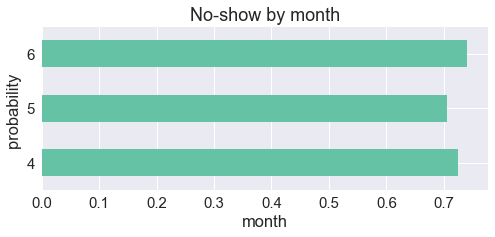

In [17]:
no_show['month'] = no_show['AppointmentDay'].dt.month
visualize_feature(no_show, 'month')

month May is the most busy month. April has only 3% of appointments.

,day,count,count%,probability
5,Wednesday,17044,0.237,0.729
3,Thursday,11325,0.157,0.727
4,Tuesday,16462,0.229,0.713
2,Saturday,31,0.000,0.710
0,Friday,12516,0.174,0.706
1,Monday,14581,0.203,0.698


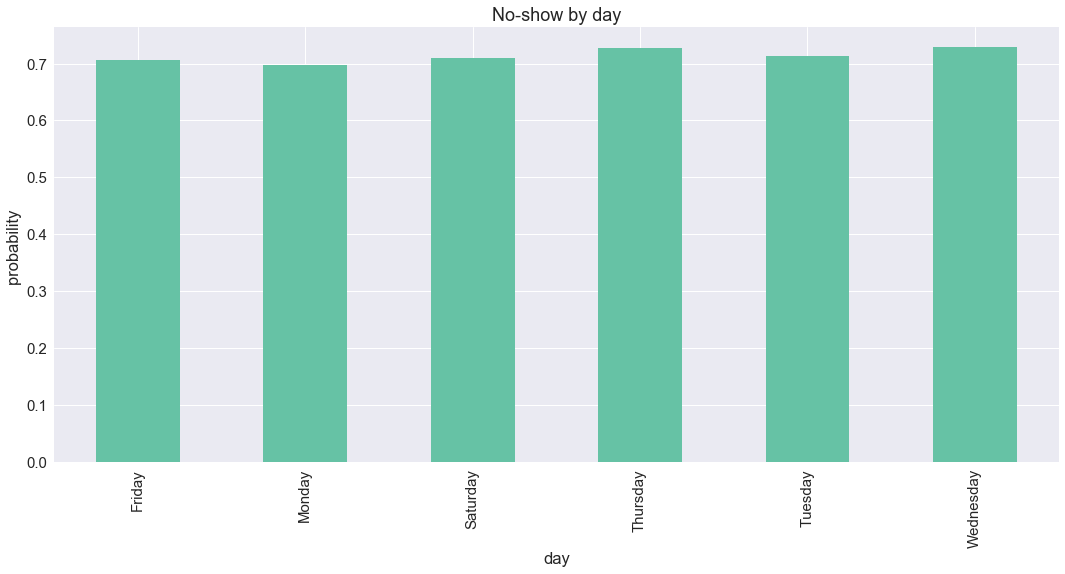

In [18]:
no_show['day']=no_show['AppointmentDay'].dt.weekday_name
visualize_feature(no_show, 'day')

Tuesday and Wednessday are busy days with more patient appointments.Saturday has least appointments probably because saturday is off.However there is no significant difference on no-show rate.

,waitdays_bucket,count,count%,probability
4,176+,10,0.000,0.800
1,101-125,58,0.001,0.776
0,0-25,57069,0.793,0.724
7,76-100,430,0.006,0.721
6,51-75,2470,0.034,0.694
5,26-50,11853,0.165,0.673
3,151-175,45,0.001,0.667
2,126-150,24,0.000,0.542


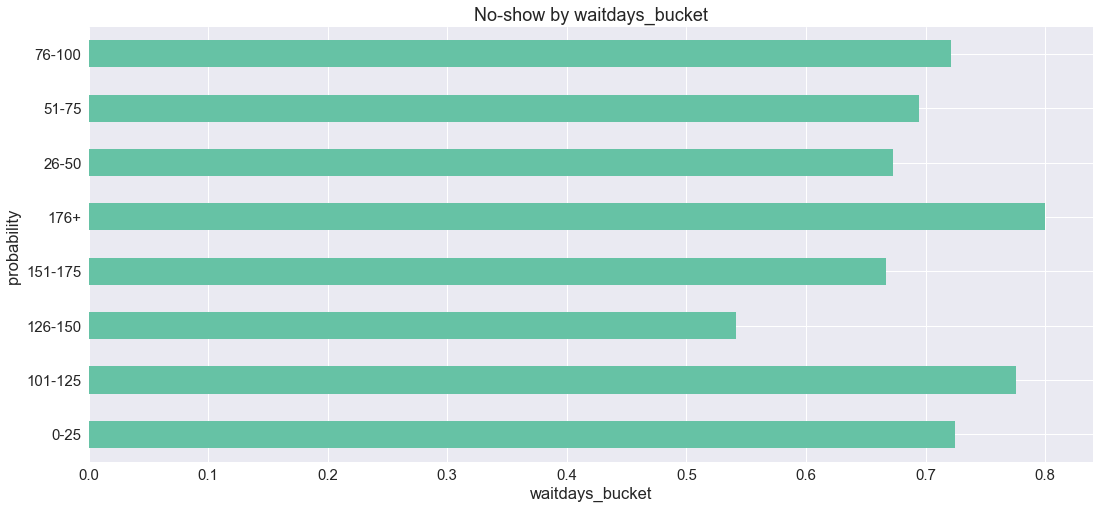

In [19]:

visualize_feature(no_show, 'waitdays_bucket')

79% of patients wait less than 25 days

,Gender,count,count%,probability
0,F,48070,0.668,0.716
1,M,23889,0.332,0.713


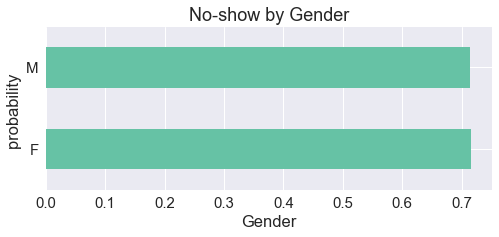

In [20]:
visualize_feature(no_show, 'Gender')

Females patients are 3.3 times more than male however there is no significant difference on no-show rate.

Percentage of no show up is more among female patients. There are much more women data than men data in the dataset.

,HandiCap,count,count%,probability
3,3,8,0.000,0.750
1,1,1185,0.016,0.749
0,0,70652,0.982,0.714
2,2,112,0.002,0.696
4,4,2,0.000,0.500


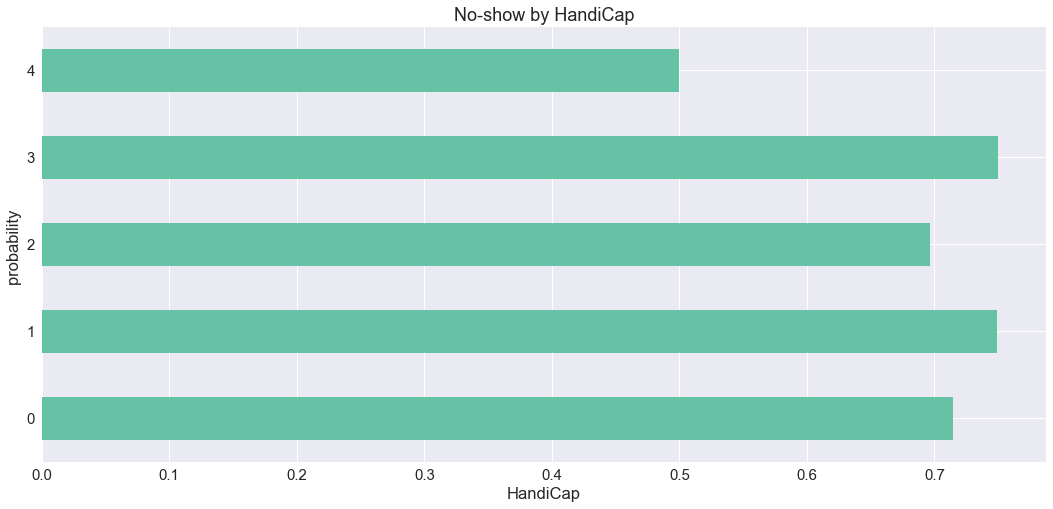

In [21]:
visualize_feature(no_show, 'HandiCap')

About 2% of the patients are handicap.

Patients with disability=4 tend to not miss the appointment much.

,Scholarship,count,count%,probability
0,0,65288,0.907,0.721
1,1,6671,0.093,0.650


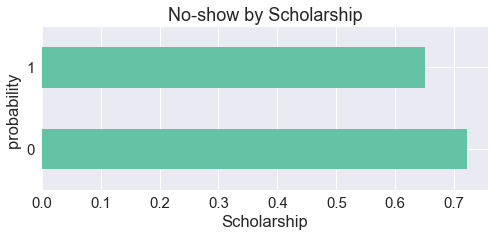

In [22]:
visualize_feature(no_show, 'Scholarship')

About 10% of the patients receive the scholarship and patients who don't receive the scholarship tend to miss the appointment more.

,Diabetes,count,count%,probability
1,1,5377,0.075,0.750
0,0,66582,0.925,0.712


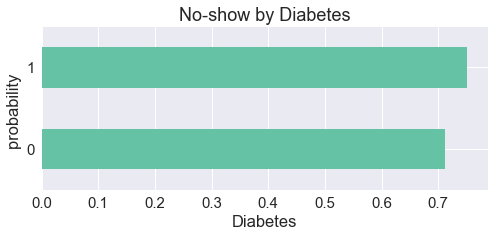

In [23]:
visualize_feature(no_show, 'Diabetes')

,Alcoholism,count,count%,probability
0,0,70137,0.975,0.716
1,1,1822,0.025,0.659


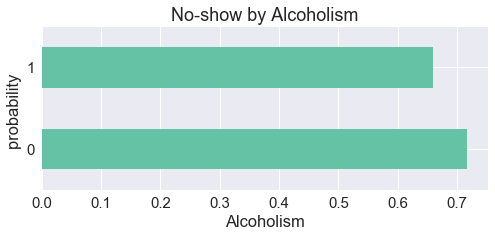

In [24]:
visualize_feature(no_show, 'Alcoholism')

Patients who are alcoholic show up more to thier appointment when compared to patients who are not alcoholic. but the difference is not significant.

,HyperTension,count,count%,probability
1,1,15032,0.209,0.765
0,0,56927,0.791,0.702


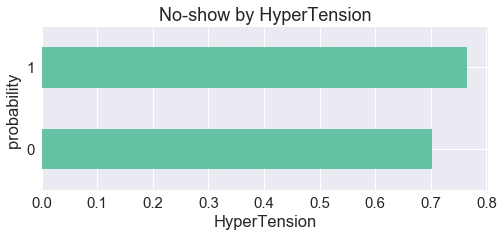

In [25]:
visualize_feature(no_show, 'HyperTension')

About 20% of the patients have hypertension. no-show is more for Patients with hypertension.

,SMS_received,count,count%,probability
1,1,35482,0.493,0.724
0,0,36477,0.507,0.706


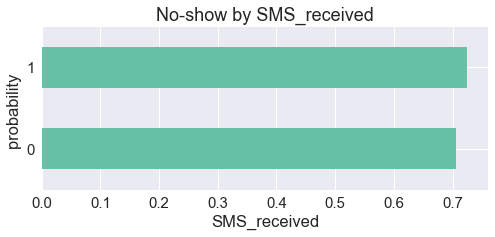

In [26]:
visualize_feature(no_show, 'SMS_received')

no show for patients who receivd email is slightly more. 

,age_bucket,count,count%,probability
6,65+,10174,0.141,0.792
5,55-64,10081,0.140,0.784
4,45-54,10351,0.144,0.744
3,35-44,9477,0.132,0.691
0,0-18,17035,0.237,0.675
2,25-34,9401,0.131,0.665
1,18-24,5440,0.076,0.640


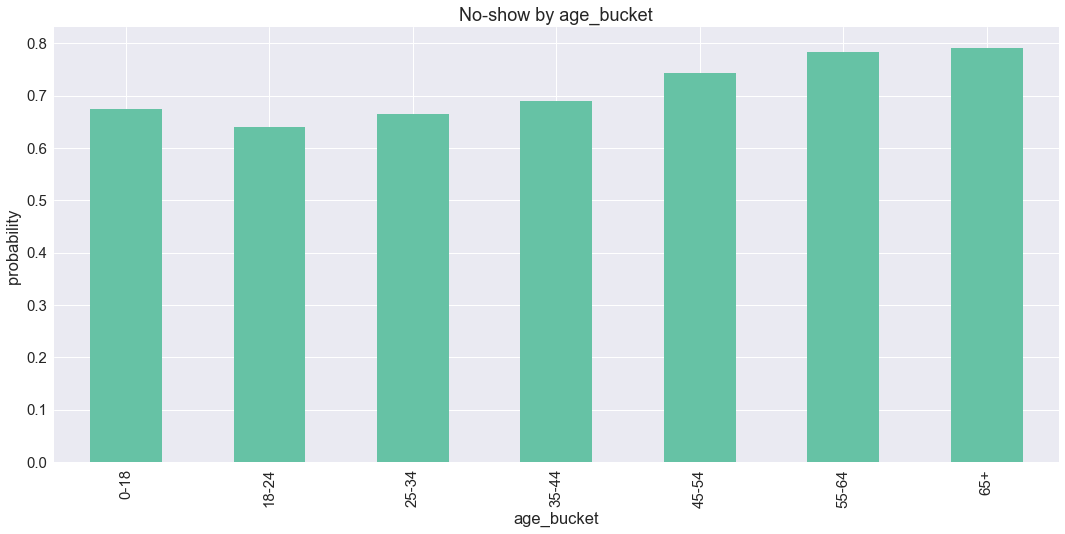

In [27]:
visualize_feature(no_show, 'age_bucket')

No show increases as the age is increasing

,Neighbourhood,count,count%,probability
31,ILHA DO BOI,23,0.000,0.913
72,SOLON BORGES,337,0.005,0.807
0,AEROPORTO,5,0.000,0.800
16,DE LOURDES,222,0.003,0.797
47,MORADA DE CAMBURI,78,0.001,0.795
45,MATA DA PRAIA,462,0.006,0.781
19,DO QUADRO,558,0.008,0.781
17,DO CABRAL,362,0.005,0.779
39,JARDIM DA PENHA,2655,0.037,0.775
79,VILA RUBIM,598,0.008,0.773


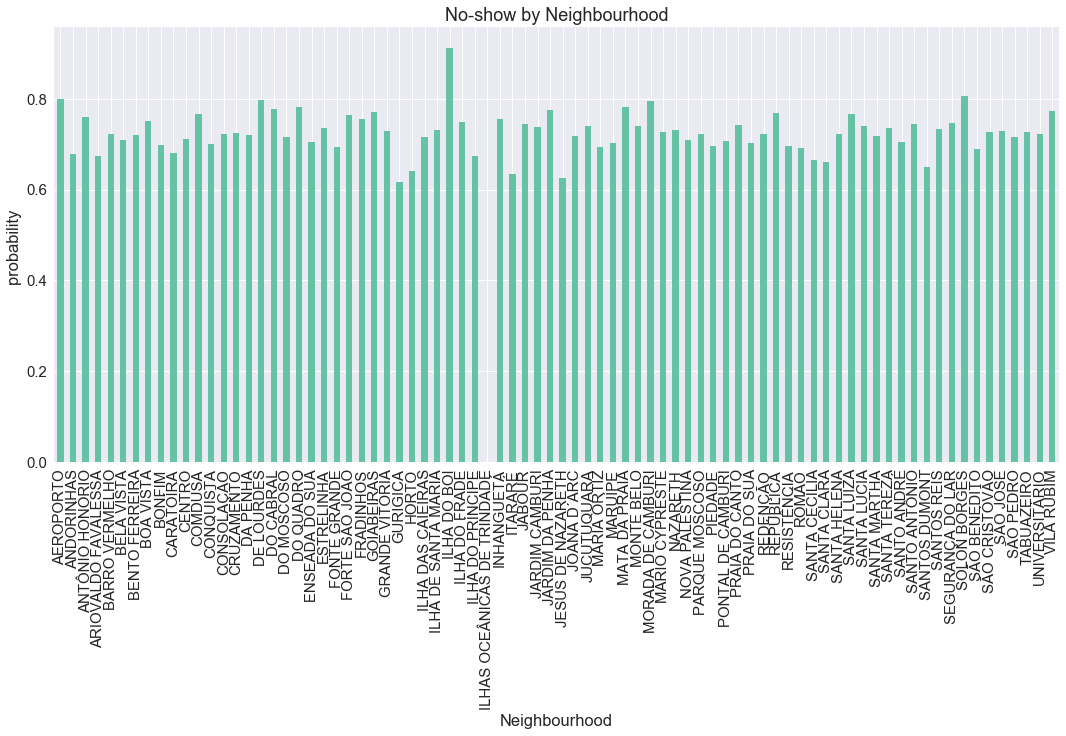

In [28]:
visualize_feature(no_show, 'Neighbourhood')

JARDIM CAMBURI Neighbourhood has more patients about 7% with 74% no show.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <a list of 11 Text xticklabel objects>)

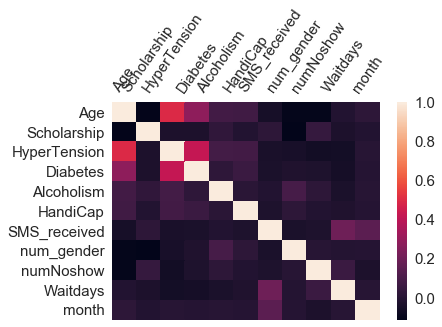

In [29]:
no_show_corr=no_show.drop(['PatientId','AppointmentID','No-show','Gender','age_bucket'],axis=1)
corr=no_show_corr.corr()
sns.heatmap(corr, vmax=1., square=False).xaxis.tick_top()
plt.xticks(rotation=55)

From the above correlation graph, there are no strong relationship to determine whether or not a patient will miss a visit (given by the numNoshows column). It appears that there are not even any strong relationships whatsoever though there is a moderate relationship between age and hypertension.

###  Inferential Statistics

### Analyzing relation between no-show and Gender

In [30]:
import scipy.stats as stats

noshow = np.array(no_show.Age[no_show.numNoshow == 0])
show = np.array(no_show.Age[no_show.numNoshow == 1])

stats.ttest_ind(noshow,show,equal_var=False,nan_policy='omit')


Ttest_indResult(statistic=27.865688525153512, pvalue=2.997656460913841e-169)

NULL HYPOTHESIS: There is no Geneder effect regarding those who miss the appointmnet( Sample mean of male=sample mean of female)
ALTERNATE HYPOTHESIS:There is Geneder effect regarding those who miss the appointmnet( Sample mean of male != sample mean of female)

In [31]:
female = np.array(no_show.numNoshow[no_show.Gender == 'F'])
male = np.array(no_show.numNoshow[no_show.Gender == 'M'])

stats.ttest_ind(female,male,equal_var=False)

Ttest_indResult(statistic=-0.6147611485498676, pvalue=0.5387154102134005)

p-value=0.53 > 0.05 (significance level) so we can not reject the null hypothesis, which implies There is no Geneder effect on no-show.

### month analysis
NULL HYPOTHESIS: There is no month effect on no-shows ( sample means of all the months are same)
ALTERNATE HYPOTHESIS: There is effect of month on no-shows ( some of sample means of the months are not same)

In [72]:
import calendar    
monthName = no_show['month'].apply(lambda x: calendar.month_name[x])
monthName=monthName.unique()

In [71]:
anova_month = pd.DataFrame({"month":no_show['month'].apply(lambda x: calendar.month_name[x]),"noshow":no_show['numNoshow']})
groups = anova_month.groupby("month").groups

# Etract individual groups
April = no_show['numNoshow'][groups["April"]]
May = no_show['numNoshow'][groups["May"]]
June = no_show['numNoshow'][groups["June"]]

# Perform the ANOVA
stats.f_oneway(April,May,June)

F_onewayResult(statistic=37.52590631278254, pvalue=5.142795870259545e-17)

Based on P-Value, which is less than significant value=0.05 we can reject the NULL hypothesis.so some of the sample means of the months is different.We can not determine for which month sample mean is different.

Post-hoc test is used to find for which month sample mean is different.

### post-hoc test is to perform a separate t-test for each pair of groups.

In [75]:
# Get all month pairs
month_pairs = []

for month1 in range(2):
    for month2  in range(month1+1,3):
        month_pairs.append((monthName[month1], monthName[month2]))

# Conduct t-test on each pair
for month1, month2 in month_pairs: 
    print(month1, month2)
    print(stats.ttest_ind(no_show['numNoshow'][groups[month1]], 
                          no_show['numNoshow'][groups[month2]]))

April May
Ttest_indResult(statistic=-1.8613099987694142, pvalue=0.06270578092378136)
April June
Ttest_indResult(statistic=1.551562333784281, pvalue=0.120783188498355)
May June
Ttest_indResult(statistic=8.599715216162453, pvalue=8.153741138839527e-18)


Based on P-value of month pairs, may,june pair has sample mean different.

### weekday analysis

NULL HYPOTHESIS: There is no weekday effect on no-shows ( sample means of all the weekdays are same)
ALTERNATE HYPOTHESIS: There is effect of weekday on no-shows ( some of sample means of the weekdays are not same)

In [82]:
weekday_df = pd.DataFrame({"day":no_show['day'],"noshow":no_show['numNoshow']})
groups = weekday_df.groupby("day").groups
weekday=no_show['day'].unique()
# Etract individual groups
Monday = no_show['numNoshow'][groups["Monday"]]
Tuesday = no_show['numNoshow'][groups["Tuesday"]]
Wednesday = no_show['numNoshow'][groups["Wednesday"]]
Thursday = no_show['numNoshow'][groups["Thursday"]]
Friday = no_show['numNoshow'][groups["Friday"]]
Saturday = no_show['numNoshow'][groups["Saturday"]]


# Perform the ANOVA
stats.f_oneway(Monday,Tuesday,Wednesday,Thursday,Friday,Saturday)

F_onewayResult(statistic=9.879047432367775, pvalue=1.856359294046764e-09)

In [84]:
# Get all weekday pairs
weekday_pairs = []

for wkday1 in range(5):
    for wkday2  in range(wkday1+1,6):
        weekday_pairs.append((weekday[wkday1], weekday[wkday2]))

# Conduct t-test on each pair
for wkday1,wkday2 in weekday_pairs: 
    print(wkday1,wkday2)
    print(stats.ttest_ind(no_show['numNoshow'][groups[wkday1]], 
                          no_show['numNoshow'][groups[wkday2]]))

Friday Tuesday
Ttest_indResult(statistic=1.2797265776694875, pvalue=0.20065156005636003)
Friday Monday
Ttest_indResult(statistic=-1.5359043255771103, pvalue=0.12457352358369456)
Friday Thursday
Ttest_indResult(statistic=3.571345759579587, pvalue=0.00035585077595550146)
Friday Wednesday
Ttest_indResult(statistic=4.173093844069573, pvalue=3.013495664744456e-05)
Friday Saturday
Ttest_indResult(statistic=0.03933833870856801, pvalue=0.9686212663653202)
Tuesday Monday
Ttest_indResult(statistic=-2.981660027868892, pvalue=0.0028691260139372433)
Tuesday Thursday
Ttest_indResult(statistic=2.549567482901516, pvalue=0.010790986246464636)
Tuesday Wednesday
Ttest_indResult(statistic=3.0990587846988196, pvalue=0.001942972172025406)
Tuesday Saturday
Ttest_indResult(statistic=-0.045048048162892505, pvalue=0.9640695563444217)
Monday Thursday
Ttest_indResult(statistic=5.185450327199812, pvalue=2.171123907394002e-07)
Monday Wednesday
Ttest_indResult(statistic=6.014792789302468, pvalue=1.8209176971818199e-

corrected significance level=0.05/15 is 0.003. 

### Analyzing between no-show ups and health condition

NULL HYPOTHESIS: There is no effect between health condition and no-shows ( sample means of all the health conditions is same)
ALTERNATE HYPOTHESIS: There is some effect between health condition and no-shows ( some of sample means of the weekdays are not same)

In [85]:
stats.f_oneway(no_show['HyperTension'],no_show['Diabetes'],no_show['Alcoholism'],no_show['HandiCap'])
 

F_onewayResult(statistic=7873.567420542818, pvalue=0.0)

Based on the P-value, we can not reject the NULL hypothesis, which means there is no effect between health condition and no-shows

### Analyzing between SMS and  patient's no-show rate

NULL HYPOTHESIS: There is no effect between SMS-received and no-shows ( sample mean of SMS-received = sample mean of no-show)
ALTERNATE HYPOTHESIS: There is some effect between SMS-received and no-shows ( sample mean of SMS-received != sample mean of no-show)


In [105]:
sms_df = pd.DataFrame({"SMS":no_show['SMS_received'],"noshow":no_show['numNoshow']})
sms_tab = pd.crosstab(sms_df.SMS, sms_df.noshow, margins = True)
sms_tab.columns = ["sms","no-sms", "row_totals"]
sms_tab.index = ["show","no-show","col_totals"]

observed =sms_tab.ix[0:2,0:2]   # Get table without totals for later use
observed

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,sms,no-sms
show,25739,10738
no-show,25698,9784


In [94]:
count=no_show['SMS_received'].count()
expected =  np.outer(sms_tab["row_totals"][0:2],
                     sms_tab.ix["col_totals"][0:2]) / count
expected = pd.DataFrame(expected)

expected.columns = ["sms","no-sms"]
expected.index = ["show","no-show"]

expected

,sms,no-sms
show,26074.117887,10402.882113
no-show,25362.882113,10119.117887


In [95]:
chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()

print(chi_squared_stat)

30.62866418363049


In [100]:

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence* Find t 
                      df = 1)   # *

print("Critical value")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=1)
print("P value")
print(p_value)

Critical value
3.8414588206941236
P value
3.1244352549641974e-08


P-value is less than 0.05,we can reject the NULL hypothesis. Which means there is some effect of SMS and no_shows. 



### analyzing no-show up and scholarships

NULL HYPOTHESIS: There is no effect between scholarship and no-shows ( sample mean of scholarship = sample mean of no-show)
ALTERNATE HYPOTHESIS: There is some effect between scholarship and no-shows ( sample mean of scholarship != sample mean of no-show)

In [106]:
Scholarship_tab = pd.crosstab(no_show['Scholarship'], no_show['numNoshow'], margins = True)
Scholarship_tab.columns = ["Scholarship","no-Scholarship", "row_totals"]
Scholarship_tab.index = ["show","no-show","col_totals"]

observed =Scholarship_tab.ix[0:2,0:2]   # Get table without totals for later use
observed

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


,Scholarship,no-Scholarship
show,47099,18189
no-show,4338,2333


In [107]:
count=no_show['SMS_received'].count()
expected =  np.outer(Scholarship_tab["row_totals"][0:2],
                     Scholarship_tab.ix["col_totals"][0:2]) / count
expected = pd.DataFrame(expected)

expected.columns = ["Scholarship","no-Scholarship"]
expected.index = ["show","no-show"]

expected

,Scholarship,no-Scholarship
show,46668.503676,18619.496324
no-show,4768.496324,1902.503676


In [108]:
chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()

print(chi_squared_stat)

150.20162590097152


In [110]:

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence
                      df = 1)  

print("Critical value")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=1)
print("P value")
print(p_value)

Critical value
3.8414588206941236
P value
0.0


based on p-value, we can't  reject NULL hypothesis, which implies there is no relation between scholarship and no-shows.